### Capstone Project - The Battle of Neighborhoods

In [1]:
import os
import re
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import bson

import requests # library to handle requests
from bs4 import BeautifulSoup

import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Data Ingestion

We will analyze the __Istanbul Neighborhoods__ in this project!

![title](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Galata_Kulesi_%27nden_panorama.jpg/1550px-Galata_Kulesi_%27nden_panorama.jpg)

You can get detailed information about Istanbul from the wiki page: https://en.wikipedia.org/wiki/Istanbul

#### Data 1 - Neighborhoods Population and Area

In the beginning we are scrapping the web to get the basic statistics which we will use in our project. We will examine the 3 popular borough which are in the seaside: Bakırköy, Beşiktaş, Kadıköy. 

In [2]:
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36"}
request = requests.get("https://www.atlasbig.com/tr/istanbul-mahalleleri-nufus-yogunlugu", headers)
soup = BeautifulSoup(request.text,'html.parser')
table = soup.findAll("table")[0]

data =  []
for tr in table.find_all("tr"):
    row = []
    for td in tr.find_all("td"):
        row.append(td.text.replace("\t", "").replace("\n", ""))
    data.append(row)

df = pd.DataFrame(data[1:], columns = ["RowNum", "Neighborhood", "County", "PopulationDensity", "Population", "Area"])
df.drop("PopulationDensity", axis = 1, inplace = True)
df["Neighborhood"] = df["Neighborhood"].str.strip()
df["Search"] =  df["Neighborhood"] + "," + df["County"] + ", İstanbul"


# 3 Popular County Selected
df = df[(df.County.isin(["Beşiktaş", "Bakırköy", "Kadıköy"]))]

#### Data 2 - Neighborhoods Latitude & Longitude
We are getting each neighborhoods' latitute and longitude

In [3]:
for col in ["Population", "Area"]:
    df[col] = df[col].str.replace(",", "")
    df[col] = df[col].astype("float")
df["AreaPerPerson"] = df["Area"]*1000000/df["Population"]
df = df[["Neighborhood", "County", "Search", "Population", "Area", "AreaPerPerson"]]

In [5]:
df["Latitude"]  = np.nan
df["Longitude"] = np.nan

for i in df["Search"].unique():
    geolocator = Nominatim(user_agent = "Istanbul")
    location = geolocator.geocode(i)
    lat = location.latitude
    lng = location.longitude
    
    df.loc[df["Search"] == i, "Latitude"]  = lat
    df.loc[df["Search"] == i, "Longitude"] = lng

In [7]:
df.head()

,Neighborhood,County,Search,Population,Area,AreaPerPerson,Latitude,Longitude
41,Muradiye,Beşiktaş,"Muradiye,Beşiktaş, İstanbul",5048.0,0.081,16.045959,41.048095,28.998998
129,Türkali,Beşiktaş,"Türkali,Beşiktaş, İstanbul",10346.0,0.240,23.197371,41.047674,29.002305
173,Abbasağa,Beşiktaş,"Abbasağa,Beşiktaş, İstanbul",5288.0,0.140,26.475038,41.049574,29.005171
219,Yenimahalle,Bakırköy,"Yenimahalle,Bakırköy, İstanbul",6953.0,0.230,33.079246,40.980645,28.882226
229,Cevizlik,Bakırköy,"Cevizlik,Bakırköy, İstanbul",5363.0,0.190,35.427932,40.978742,28.877184


##### Visualize the neighborhoods in the map

In [8]:
address = "Istanbul"
geolocator = Nominatim(user_agent = "Istanbul")

location = geolocator.geocode(address)

lat_ist = location.latitude
lng_ist = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, lat_ist, lng_ist))

# create map of Toronto using latitude and longitude values
map_istanbul = folium.Map(location = [lat_ist, lng_ist], zoom_start=10)

# add county markers to map
for county, lat, lng in zip(df["Search"], df["Latitude"], df["Longitude"]):
    folium.CircleMarker(
                    [lat, lng],
                    radius=10,
                    color='blue',
                    popup = county,
                    fill=True,
                    fill_color='#3186cc',
                    fill_opacity=0.7,
                    parse_html=False).add_to(map_istanbul)

map_istanbul

The geograpical coordinate of Istanbul are 41.0096334, 28.9651646.


#### Data 3 - Venues Informations of the Neighborhoods
Istanbul Neighborhoods geographical coordinates data will be input for the Foursquare API, and we will use the Foursquare API to explore the venues of neighborhoods in Istanbul.

In [62]:
#https://foursquare.com/developers/apps/YTTSV5B0SMRPXVLXOT4OTQ2ZOE1V0OQ2AZCYTEMYKXO0KA0N/settings
CLIENT_ID = "YTTSV5B0SMRPXVLXOT4OTQ2ZOE1V0OQ2AZCYTEMYKXO0KA0N" # your Foursquare ID
CLIENT_SECRET = "DKLVJ1SOU1ZSBNNBHK4CD4K0IVEFJ4BKVGXHX2KLLDVJ4M40" # your Foursquare Secret

#CLIENT_ID = 'HTEI3RFH5DTZHU5XWNSE4BIQYPMNB1MDNXPID3O04K303IQV' # your Foursquare ID
#CLIENT_SECRET = 'SUYEQBXTGB4QKND0IYAWYMQUXDR451LPGQQAR1PEWATXQQC5' # your Foursquare Secret

VERSION = '20180604'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YTTSV5B0SMRPXVLXOT4OTQ2ZOE1V0OQ2AZCYTEMYKXO0KA0N
CLIENT_SECRET:DKLVJ1SOU1ZSBNNBHK4CD4K0IVEFJ4BKVGXHX2KLLDVJ4M40


In [70]:
def getNearbyVenues(df, names, latitudes, longitudes, radius=500, limit=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
                             name, 
                             lat, 
                             lng, 
                             v['venue']['id'],
                             v['venue']['name'], 
                             v['venue']['location']['lat'], 
                             v['venue']['location']['lng'],  
                             v['venue']['categories'][0]['name']) for v in results])


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'NeighborhoodLatitude', 
                             'NeighborhoodLongitude', 
                             'VenueId',
                             'VenueName',
                             'VenueLatitude', 
                             'VenueLongitude', 
                             'VenueCategory']
    
    dfcols = ['Neighborhood', 'County', 'Population', 'Area', "AreaPerPerson"]
    df = pd.merge(df[dfcols], nearby_venues, on = "Neighborhood", how = "left")
    
    del nearby_venues
    
    return(df)

In [71]:
venuesdf = getNearbyVenues(df, names=df['Neighborhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])

In [107]:
venuesdf.to_pickle(os.getcwd()+"/data/venuesdf.pkl")
venuesdf.head()

,Neighborhood,County,Population,Area,AreaPerPerson,NeighborhoodLatitude,NeighborhoodLongitude,VenueId,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,Muradiye,Beşiktaş,5048.0,0.081,16.045959,41.048095,28.998998,5bc1c09561f070002c4e4d3c,Bread & Stuff,41.048146,28.996902,Restaurant
1,Muradiye,Beşiktaş,5048.0,0.081,16.045959,41.048095,28.998998,5ac8d36e0f013c3cc9882e05,Kiez PUB,41.046656,29.000276,Pub
2,Muradiye,Beşiktaş,5048.0,0.081,16.045959,41.048095,28.998998,58dd20d80b56566d4436a12e,Abaka,41.048363,29.001369,Café
3,Muradiye,Beşiktaş,5048.0,0.081,16.045959,41.048095,28.998998,586e4ac02896a279501d3939,321 Kolektif,41.048162,29.000360,Coffee Shop
4,Muradiye,Beşiktaş,5048.0,0.081,16.045959,41.048095,28.998998,587e1f9b52a05106f209da94,House of Brothers,41.046482,28.997500,Lounge


##### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [108]:
venuesgrouped = pd.pivot_table(venuesdf,
                               index=["Neighborhood", "County", "NeighborhoodLatitude", "NeighborhoodLongitude", 
                                      "Population", "Area", "AreaPerPerson"],
                               columns = ["VenueCategory"],
                               values = ["VenueId"],
                               aggfunc=lambda x: len(x.unique()))

venuesgrouped.columns = venuesgrouped.columns.droplevel().rename(None)
venuesgrouped = venuesgrouped.reset_index()
venuesgrouped.iloc[:,3:] = venuesgrouped.iloc[:,3:].fillna(0)

venuesgrouped.to_pickle(os.getcwd()+"/data/venuesgrouped.pkl")

In [109]:
pd.set_option("display.max_columns", 500)
venuesgrouped

,Neighborhood,County,NeighborhoodLatitude,NeighborhoodLongitude,Population,Area,AreaPerPerson,Accessories Store,Advertising Agency,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Boxing Gym,Breakfast Spot,Bridal Shop,Buffet,Burger Joint,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Cigkofte Place,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Gym,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cruise,Cupcake Shop,Dance Studio,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,Gift Shop,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kofte Place,Kokoreç Restaurant,Kumpir Restaurant,Kuruyemişçi,Lawyer,Lebanese Restaurant,Library,Lighthouse,Lingerie Store,Lounge,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Meyhane,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Nature Preserve,Nightclub,Non-Profit,Office,Optical Shop,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Pide Place,Pie Shop,Pier,Pilates Studio,Pilavcı,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Professional & Other Places,Pub,Public Art,Racetrack,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Salsa Club,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Surf Spot,Sushi Restaurant,Swiss Restaurant,Taco Place,Tantuni Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Tennis Stadium,Theater,Theme Park,Theme Restaurant,Toy / Game Store,Track,Track Stadium,Trail,Train Station,Travel Agency,Tunnel,Turkish Home Cooking Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Volleyball Court,Watch Shop,Water Park,Waterfront,Whisky Bar,Wine Bar,Winery,Wings Joint,Women's Store,Yoga Studio
0,19 Mayıs,Kadıköy,40.980720,29.078622,30310.0,1.300,42.890135,0.0,0.0

In [110]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [113]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venuessorted = pd.DataFrame(columns=columns)
venuessorted['Neighborhood'] = venuesgrouped['Neighborhood']
venuessorted

for ind in np.arange(venuesgrouped.iloc[:,7:].shape[0]):
    venuessorted.iloc[ind, 1:]
    venuessorted.iloc[ind, 1:] = return_most_common_venues(venuesgrouped.iloc[ind, 7:], num_top_venues)

venuessorted.to_pickle(os.getcwd()+"/data/venuessorted.pkl")

In [114]:
venuessorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,19 Mayıs,Café,Ice Cream Shop,Seafood Restaurant,Turkish Restaurant,Gym / Fitness Center,Pilates Studio,Park,Martial Arts Dojo,Bakery,Grocery Store
1,Abbasağa,Coffee Shop,Café,Turkish Restaurant,Burger Joint,Historic Site,Gym / Fitness Center,Soccer Stadium,Lounge,Pub,Park
2,Acıbadem,Café,Gym,Restaurant,Fast Food Restaurant,Kebab Restaurant,Bakery,Coffee Shop,Turkish Restaurant,Dessert Shop,Pharmacy
3,Akatlar,Café,Gym / Fitness Center,Italian Restaurant,Kebab Restaurant,Gym,Gym Pool,Tennis Court,Coffee Shop,Steakhouse,Sushi Restaurant
4,Arnavutköy,Seafood Restaurant,Café,Art Gallery,Restaurant,Coffee Shop,Music Venue,Lounge,Pastry Shop,Scenic Lookout,Farmers Market
5,Ataköy 1. kısım,Café,Coffee Shop,Restaurant,Clothing Store,Hotel,Turkish Restaurant,Kebab Restaurant,Seafood Restaurant,Yoga Studio,Bookstore
6,Ataköy 2-5-6. kısım,Café,Coffee Shop,Restaurant,Spa,Gym / Fitness Center,Hotel,Seafood Restaurant,Turkish Restaurant,Clothing Store,Sushi Restaurant
7,Ataköy 3-4-11. kısım,Café,Park,Tennis Court,Coffee Shop,Train Station,Restaurant,Grocery Store,Playground,Hotel,Boarding House
8,Ataköy 7-8-9-10. kısım,Café,Pizza Place,Dog Run,Sporting Goods Shop,Trail,Burger Joint,Scenic Lookout,Beer Garden,Steakhouse,Salon / Barbershop
9,Balmumcu,Café,Motorcycle Shop,Hotel,Italian Restaurant,Bar,Coffee Shop,Turkish Restaurant,Gym / Fitness Center,Seafood Restaurant,Office


### Clustering Neighborhoods

In [43]:
uselesscols = ["Neighborhood", "County", "NeighborhoodLatitude", "NeighborhoodLongitude", "Population", "Area"]
clustercols = venuesdf.columns[~venuesdf.columns.isin(uselesscols)]
clustercols

Index(['AreaPerPerson', 'Accessories Store', 'Advertising Agency',
       'African Restaurant', 'American Restaurant', 'Antique Shop', 'Aquarium',
       'Arcade', 'Art Gallery', 'Art Museum',
       ...
       'Volleyball Court', 'Watch Shop', 'Water Park', 'Waterfront',
       'Whisky Bar', 'Wine Bar', 'Winery', 'Wings Joint', 'Women's Store',
       'Yoga Studio'],
      dtype='object', length=283)

In [67]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

In [68]:
# Standardize data
scaler = MinMaxScaler() 
scaledvenuesdf = scaler.fit_transform(venuesdf[clustercols]) 
# Normalizing the Data 
#normalizedvenuesdf = normalize(scaledvenuesdf) 
# Converting the numpy array into a pandas DataFrame 
#normalizedvenuesdf = pd.DataFrame(normalizedvenuesdf)

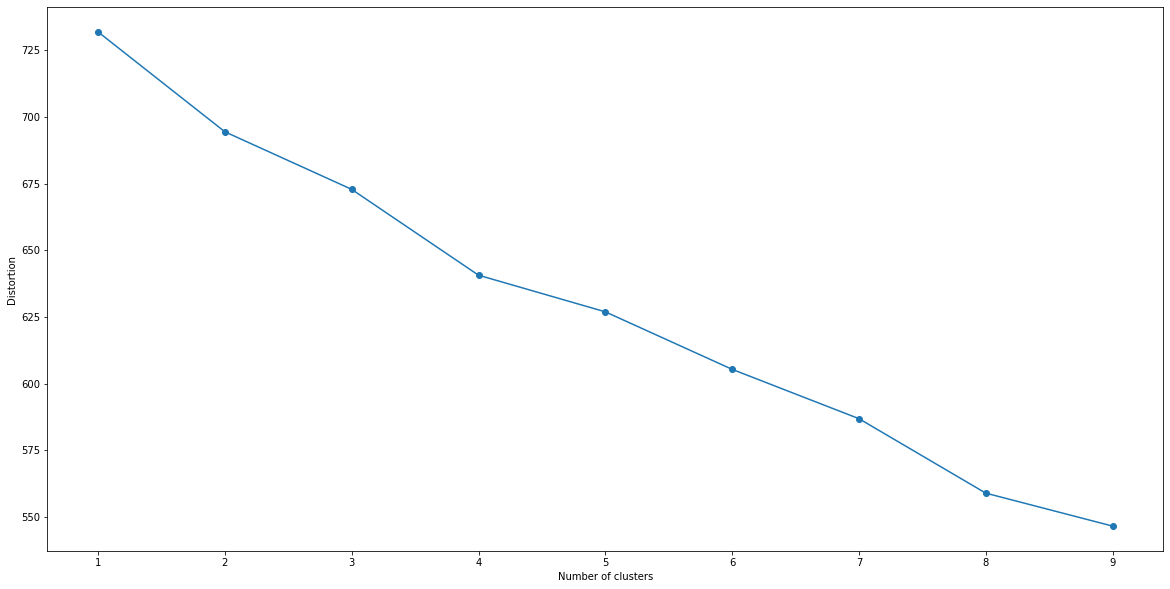

In [118]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 10):
    km = KMeans(n_clusters=i)
    km.fit(scaledvenuesdf)
    distortions.append(km.inertia_)

#plot
plt.figure(figsize = (20, 10))
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()